In [90]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [91]:
delf = pd.read_csv(r"C:\Users\Sam\Downloads\diminos_data_v2\diminos_data_v2\order_items.csv")

In [92]:
delf.head()

,order_id,time_stamp,status
0,321230114,2020-12-11 00:01:29.000000000,Pending
1,321230114,2020-12-11 00:06:29.000000000,Out For Delivery
2,321230114,2020-12-11 00:19:13.299151076,Delivered
3,321230115,2020-12-11 00:36:02.000000000,Pending
4,321230115,2020-12-11 00:41:02.000000000,Out For Delivery


In [93]:
delf['time_stamp'] = pd.to_datetime(delf['time_stamp'])

In [94]:
osf = pd.read_csv(r"C:\Users\Sam\Downloads\diminos_data_v2\diminos_data_v2\order_items.csv")

In [95]:
osf.head()

,order_id,order_placed_at
0,321230114,2020-12-11 00:01:29
1,321230115,2020-12-11 00:36:02
2,321230116,2020-12-11 00:55:01
3,321230117,2020-12-11 01:05:27
4,321230118,2020-12-11 01:14:20


In [96]:
osf['order_placed_at'] = pd.to_datetime(osf['order_placed_at'])

In [97]:
merged_df = pd.merge(delf, osf, on='order_id', how='inner')

merged_df['delivery_time'] = merged_df['time_stamp'] - merged_df['order_placed_at']

merged_df['delivery_time_minutes'] = merged_df['delivery_time'] / pd.Timedelta(minutes=1)

average_delivery_time = merged_df[merged_df['status'] == 'Delivered']['delivery_time_minutes'].mean()

average_delivery_time_rounded = round(average_delivery_time, 2)

print("Average Delivery Time (in minutes):", average_delivery_time_rounded)

Average Delivery Time (in minutes): 20.65


In [98]:
percentile_99 = merged_df[merged_df['status'] == 'Delivered']['delivery_time_minutes'].quantile(0.99)

percentile_delivery_time_rounded = round(percentile_99, 0)

print("99th Percentile Delivery Time (in minutes):", percentile_delivery_time_rounded)

99th Percentile Delivery Time (in minutes): 31.0


In [99]:
max_delivery_time_row = merged_df[merged_df['delivery_time'] == merged_df['delivery_time'].max()]

order_id_with_max_delivery_time = max_delivery_time_row['order_id'].iloc[0]

print("Order ID with the maximum delivery time:", order_id_with_max_delivery_time)

Order ID with the maximum delivery time: 321629049


In [100]:
orders_between_dates = osf[(osf['order_placed_at'] >= '2024-01-01') & 
                                           (osf['order_placed_at'] <= '2024-01-31')]

num_orders = orders_between_dates.shape[0]

print("Number of pizzas ordered between 1st January and 31st January 2024 (inclusive):", num_orders)

Number of pizzas ordered between 1st January and 31st January 2024 (inclusive): 11894


In [101]:
orders_delivered_between_dates = merged_df[(merged_df['time_stamp'] >= '2024-01-01') & 
                                           (merged_df['time_stamp'] <= '2024-01-31')]

orders_more_than_30_minutes = orders_delivered_between_dates[orders_delivered_between_dates['delivery_time_minutes'] > 30]

num_orders_more_than_30_minutes = orders_more_than_30_minutes.shape[0]

print("Number of orders that took more than 30 minutes to deliver between 1st January and 31st January 2024 (inclusive):", num_orders_more_than_30_minutes)

Number of orders that took more than 30 minutes to deliver between 1st January and 31st January 2024 (inclusive): 158


In [102]:
psf = pd.read_csv(r"C:\Users\Sam\Downloads\diminos_data_v2\diminos_data_v2\products.csv")

In [103]:
psf.head()

,item_id,category,Item,Size,Price
0,p_001,Veg,Margherita,Regular,109
1,p_002,Veg,Margherita,Medium,245
2,p_003,Veg,Margherita,Large,455
3,p_004,Veg,Double Cheese Margherita,Regular,215
4,p_005,Veg,Double Cheese Margherita,Medium,385


In [104]:
oif = pd.read_csv(r"C:\Users\Sam\Downloads\diminos_data_v2\diminos_data_v2\order_items.csv")

In [105]:
oif.head()

,order_id,items_ordered
0,321230114,"['p_025', 'p_032', 'p_037']"
1,321230115,"['p_017', 'p_012']"
2,321230116,"['p_027', 'p_037']"
3,321230117,"['p_004', 'p_029']"
4,321230118,"['p_017', 'p_037']"


In [106]:
refund_percentage = 1.0

merged_df1 = pd.merge(merged_df, oif, on='order_id', how='inner')
merged_df1['items_ordered'] = merged_df1['items_ordered'].apply(eval)
merged_df1 = merged_df1.explode('items_ordered')
merged_df1 = pd.merge(merged_df1, psf, left_on='items_ordered', right_on='item_id', how='left')

merged_df1['delivery_time'] = merged_df1['time_stamp'] - merged_df1['order_placed_at']

merged_df1['delivery_time_minutes'] = merged_df1['delivery_time'] / pd.Timedelta(minutes=1)

late_deliveries_2023 = merged_df1[(merged_df1['order_placed_at'].dt.year == 2023) & 
                                 (merged_df1['delivery_time_minutes'] > 30)]

late_deliveries_2023['refund_amount'] = late_deliveries_2023['Price'] * refund_percentage

total_loss_2023 = late_deliveries_2023['refund_amount'].sum()

print("Total amount the pizza store lost in 2023 due to refunds on late deliveries:", total_loss_2023)

Total amount the pizza store lost in 2023 due to refunds on late deliveries: 1826393.0


In [107]:
late_deliveries_refunds = merged_df1[(merged_df1['status'] == 'Delivered') & (merged_df1['delivery_time_minutes'] > 30)]

late_deliveries_refunds['refund_amount'] = late_deliveries_refunds['Price']

refund_amount_by_year = late_deliveries_refunds.groupby(pd.to_datetime(late_deliveries_refunds['order_placed_at']).dt.year)['refund_amount'].sum()

max_refund_year = refund_amount_by_year.idxmax()

print("Year with the maximum total refund amount:", max_refund_year)

Year with the maximum total refund amount: 2023


In [108]:
total_revenue = merged_df1['Price'].sum()
total_refund_amount = late_deliveries_refunds['Price'].sum()
revenue_after_refunds = total_revenue - total_refund_amount
print("Total revenue generated by the pizza store till date (excluding refund amount):", revenue_after_refunds)

Total revenue generated by the pizza store till date (excluding refund amount): 1217979030


In [109]:
osf['hour'] = osf['order_placed_at'].dt.hour

orders_per_hour = osf.groupby('hour').size()

average_orders_per_hour = orders_per_hour.mean()

print("Average number of orders per hour:", average_orders_per_hour)

Average number of orders per hour: 18930.666666666668


In [110]:
import numpy as np
Peak_hour = np.argmax(orders_per_hour)
Peak_hour

17

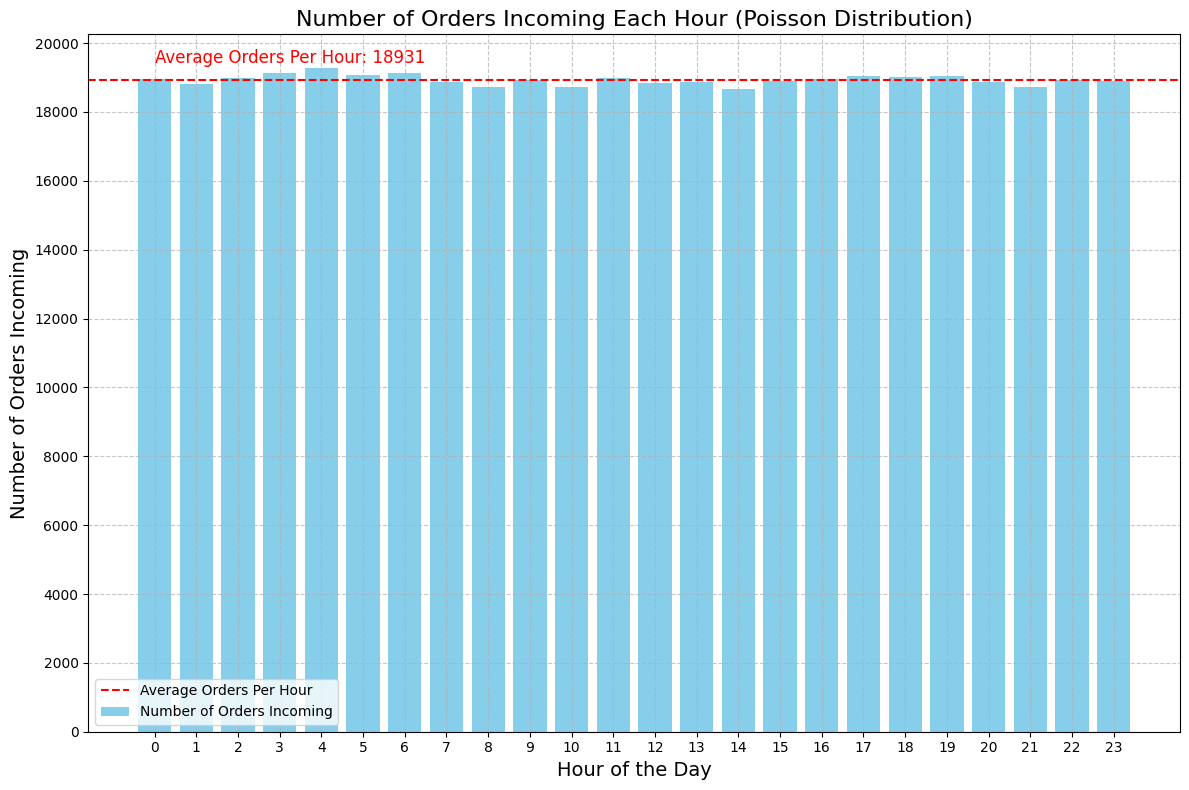

In [111]:
import matplotlib.pyplot as plt

average_orders_per_hour = 18931

num_hours = 24

orders_per_hour = np.random.poisson(average_orders_per_hour, num_hours)

plt.figure(figsize=(12, 8))
plt.bar(range(num_hours), orders_per_hour, color='skyblue', label='Number of Orders Incoming')
plt.axhline(y=average_orders_per_hour, color='red', linestyle='--', label='Average Orders Per Hour')
plt.text(0, average_orders_per_hour + 500, f'Average Orders Per Hour: {average_orders_per_hour}', color='red', fontsize=12)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Number of Orders Incoming', fontsize=14)
plt.title('Number of Orders Incoming Each Hour (Poisson Distribution)', fontsize=16)
plt.xticks(range(num_hours))
plt.yticks(np.arange(0, max(orders_per_hour) + 1000, 2000))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Mean number of orders per hour: 18930.958333333332
Variance of number of orders per hour: 21286.78993055555


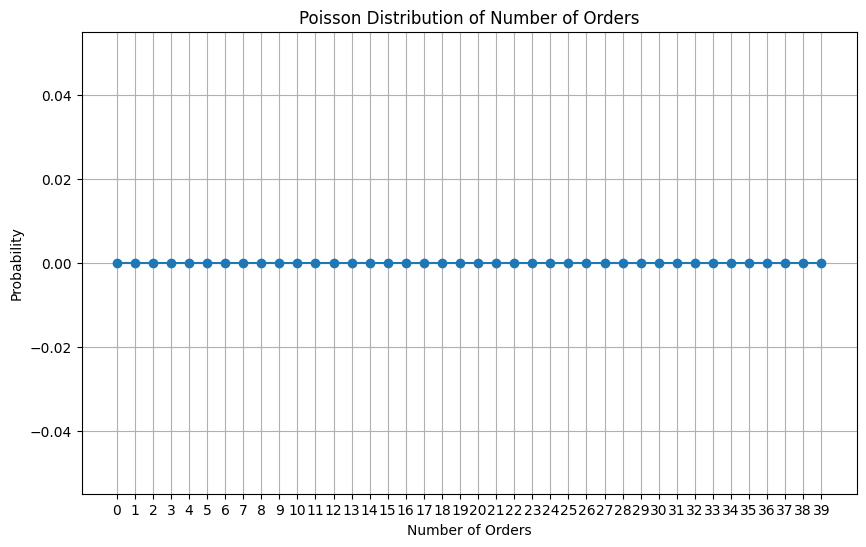

In [112]:
from scipy.stats import poisson
mean_orders_per_hour = np.mean(orders_per_hour)
variance_orders_per_hour = np.var(orders_per_hour)
print("Mean number of orders per hour:", mean_orders_per_hour)
print("Variance of number of orders per hour:", variance_orders_per_hour)

poisson_dist = poisson(mu=average_orders_per_hour)

x = np.arange(0, 40)
pmf = poisson_dist.pmf(x)

plt.figure(figsize=(10, 6))
plt.plot(x, pmf, marker='o', linestyle='-')
plt.title('Poisson Distribution of Number of Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Probability')
plt.grid(True)
plt.xticks(x)
plt.show()

## Problem for the owner of the Pizza Store that can be solved using Poisson distribution:
### Staffing and Resource Allocation:
### The owner can use the Poisson distribution to model the expected number of orders incoming each hour.
### By understanding the distribution of orders, the owner can allocate staff and resources more efficiently.
### They can schedule more staff during peak hours (e.g., hours with higher probabilities in the Poisson distribution)
### to handle the higher order volumes and ensure timely delivery, while reducing staffing levels during slower hours